<a href="https://colab.research.google.com/github/SaeSimcheon/recommendation_system/blob/main/Code_for_Man_Li_et_al_(2021).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memo

## 0210
- First code
- I realized it from the first sentence of 4 page that the dimension of columns does not vary from user to user, but is same. So I will revise the codes from "Collaborative filtering recommendation algorithm based on user preference derived from item domain features" to "Define a function to make Tiq". 

## 0212

- At start, I tried to revise the codes mentioned above.

- I wrote a draft for skap algorithm

  - **In rbf kernel, the guide line for parameter $\sigma$ is needed.**
    - [rbf](https://en.wikipedia.org/wiki/Radial_basis_function_kernel)
    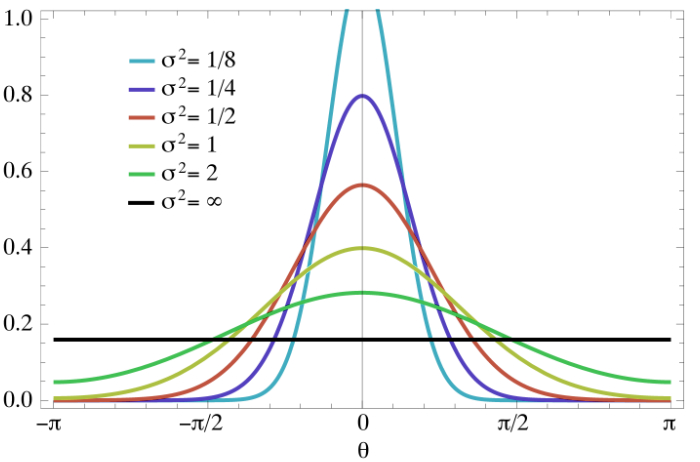
  - Check [an author's code](https://github.com/yangyuchen0340/Kind/blob/master/Kind/_KindAP.py) which is given in different paper.
  - Revise the code.
## 0215

- **Z is a very spase matrix.**



## Setup

In [ ]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

## Download the MovieLens dataset and prepare the data

The small version of the MovieLens dataset includes around 100k ratings
from 610 users on 9,742 movies.

First, let's download the dataset. The downloaded folder will contain
three data files: `users.csv`, `movies.csv`, and `ratings.csv`. In this example,
we will only need the `movies.dat`, and `ratings.dat` data files.

In [ ]:
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()

Then, we load the data into a Pandas DataFrame and perform some basic preprocessing.

In [ ]:
# Load movies to a DataFrame.
movies = pd.read_csv("ml-latest-small/movies.csv")
# Create a `movieId` string.
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

# Load ratings to a DataFrame.
ratings = pd.read_csv("ml-latest-small/ratings.csv")
# Convert the `ratings` to floating point
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
# Create the `movie_id` string.
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


## Merge ratings and movies by movieId

In [ ]:
ratings_movies=pd.merge(ratings,movies,how = "left",on = "movieId").drop(["timestamp","title"],axis = 1)

### A special genre case
- movies.loc[movies.genres == "(no genres listed)",:] -> few cases exist

### MultiLabel(list) -> onehon encoding using MultiLabelBinarizer()

    list2series = pd.Series(movies.genres.str.split("|"))
    mlb = MultiLabelBinarizer()
    one_hot_genres = pd.DataFrame(mlb.fit_transform(list2series),columns=mlb.classes_,index=list2series.index)

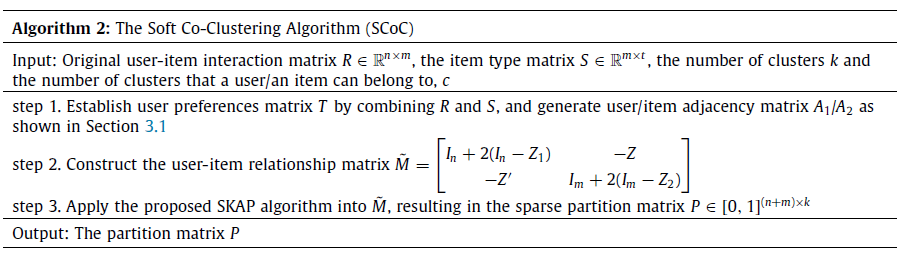

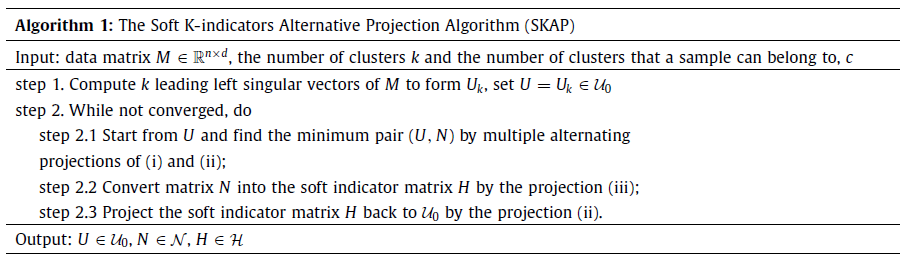

# User / item adjacency matrix construction (page4)

- [Collaborative filtering recommendation algorithm based on user preference derived from item domain features](https://www.sciencedirect.com/science/article/pii/S0378437113010558)

In [ ]:
list2series = pd.Series(movies.genres.str.split("|"))
mlb = MultiLabelBinarizer()
All_one_hot_genres = pd.DataFrame(mlb.fit_transform(list2series),columns=mlb.classes_,index=list2series.index)

All_one_hot_genres=pd.concat([movies.movieId,All_one_hot_genres],axis=1)

## An example : userId == 1 case

In [ ]:
# extract data and save it into tmp.
tmp=ratings.loc[ratings.userId == 1,:]

In [ ]:
All_one_hot_genres

In [ ]:
a_user_one_hot_genres=pd.merge(tmp,All_one_hot_genres,how = "left",on = "movieId").drop(["rating","userId","movieId","timestamp"],axis=1)

In [ ]:
a_user_one_hot_genres

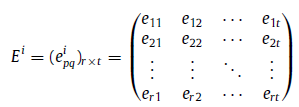

The above is defined as "Ei"

In [ ]:
Ei=np.multiply(a_user_one_hot_genres,tmp.rating[:, np.newaxis])
Ei

In [ ]:
Ei


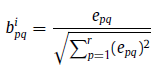

The above equation and denominator of it are "bpqi" and "denom" respectively



In [ ]:
denom=Ei.apply(lambda x : np.sqrt(sum(x**2)),axis=0)
1/denom

x1.shape


x1 = np.arange(9.0).reshape((3, 3))

x2 = np.arange(3.0)
print(x1,x2,sep='\n')
np.multiply(x1, x2)

In [ ]:
bpqi=np.multiply(Ei,1/denom)
bpqi

$$
(b_{q}^i)^* = \frac{1}{r}\sum_{p=1}^{r}b_{pq}
$$

The above is defined as "bstar"

In [ ]:
bstar=bpqi.apply(np.mean,axis=0)
bstar

$$
b_{pq}^i - (b_q^i)^*
$$

The above is defined as 'mat_bpqi_minus_bstar' matrix.

More specifically,

\begin{pmatrix}
b_{11}^i - (b_1^i)^*& \ldots & b_{1t}^i - (b_t^i)^*\\
\vdots & \ddots & \vdots \\
b_{r1}^i - (b_1^i)^*& \ldots & b_{rt}^i - (b_t^i)^*
\end{pmatrix}

In [ ]:
bpqi

In [ ]:
mat_bpqi_minus_bstar = np.add(bpqi, -bstar) #bpqi - bstar 같은 결과

(mat_bpqi_minus_bstar**2).sum(axis =0)

Using the result above, the equation below is made as vector form. 

$$
\sum_{p=1}^{r}[b_{pq}^i - (b_q^i)^*]^2
$$


Saved to "sum_mat_bpqi_minus_bstar".


We can easily calculate the reverse of it.


$$
\frac{1}{\sum_{p=1}^{r}[b_{pq}^i - (b_q^i)^*]^2}
$$


In [ ]:
sum_mat_bpqi_minus_bstar=mat_bpqi_minus_bstar.apply(lambda x : sum(x **2),axis=0)

In [ ]:
sum_mat_bpqi_minus_bstar**(-1)

(no genres listed)         NaN
Action                1.603510
Adventure             1.553578
Animation             1.140291
Children              1.214889
Comedy                1.529555
Crime                 1.230489
Documentary                NaN
Drama                 1.400446
Fantasy               1.243559
Film-Noir             1.004329
Horror                1.072138
IMAX                       NaN
Musical               1.102698
Mystery               1.077031
Romance               1.123465
Sci-Fi                1.200536
Thriller              1.289521
War                   1.102351
Western               1.030279
dtype: float64

In [ ]:
r_sum_mat_bpqi_minus_bstar = 1/sum_mat_bpqi_minus_bstar
r_sum_mat_bpqi_minus_bstar

(no genres listed)         NaN
Action                1.603510
Adventure             1.553578
Animation             1.140291
Children              1.214889
Comedy                1.529555
Crime                 1.230489
Documentary                NaN
Drama                 1.400446
Fantasy               1.243559
Film-Noir             1.004329
Horror                1.072138
IMAX                       NaN
Musical               1.102698
Mystery               1.077031
Romance               1.123465
Sci-Fi                1.200536
Thriller              1.289521
War                   1.102351
Western               1.030279
dtype: float64

$$
\sum_{q=1}^{t}\frac{1}{\sum_{p=1}^{r}[b_{pq}^i - (b_q^i)^*]^2}
$$

In [ ]:
sum_r_sum_mat_bpqi_minus_bstar = np.sum(r_sum_mat_bpqi_minus_bstar)

In [ ]:
sum_r_sum_mat_bpqi_minus_bstar

20.918661513631353

$$
T_{iq} =  \{\sum_{q=1}^{t}\frac{1}{\sum_{p=1}^{r}[b_{pq}^i - (b_q^i)^*]^2}\sum_{p=1}^{r}[b_{pq}^i - (b_q^i)^*]^2\}^{-1}
$$


T_iq is a vector which means that a user the preferences for each item type.

In [ ]:
#Tiq=1/(sum_mat_bpqi_minus_bstar / sum_r_sum_mat_bpqi_minus_bstar)
Tiq=1/(sum_r_sum_mat_bpqi_minus_bstar * sum_mat_bpqi_minus_bstar)

In [ ]:
sum_mat_bpqi_minus_bstar

(no genres listed)         NaN
Action                0.623632
Adventure             0.643676
Animation             0.876969
Children              0.823121
Comedy                0.653785
Crime                 0.812685
Documentary                NaN
Drama                 0.714058
Fantasy               0.804143
Film-Noir             0.995690
Horror                0.932716
IMAX                       NaN
Musical               0.906867
Mystery               0.928479
Romance               0.890104
Sci-Fi                0.832961
Thriller              0.775482
War                   0.907152
Western               0.970611
dtype: float64

# Define a function to make Tiq

In [ ]:
ratings_movies.userId

In [ ]:
'''
  tmp=ratings_movies.loc[ratings_movies.userId == userid,:]
  list2series = pd.Series(tmp.genres.str.split("|"))
  mlb = MultiLabelBinarizer()
  one_hot_genres = pd.DataFrame(mlb.fit_transform(list2series),columns=mlb.classes_,index=list2series.index)


  tmp_concated=pd.concat([tmp,one_hot_genres],axis=1).drop(["rating","userId","movieId","genres"],axis=1)
  Ei=np.multiply(one_hot_genres,tmp.rating[:, np.newaxis])
  denom=Ei.apply(lambda x : np.sqrt(sum(x**2)),axis=0)
  bpqi=np.multiply(Ei,1/denom)
  bstar=bpqi.apply(np.mean,axis=0)

  mat_bpqi_minus_bstar = np.add(bpqi, -bstar) #bpqi - bstar 같은 결과
  sum_mat_bpqi_minus_bstar=mat_bpqi_minus_bstar.apply(lambda x : sum(x **2),axis=0)

  r_sum_mat_bpqi_minus_bstar = 1/sum_mat_bpqi_minus_bstar
  sum_r_sum_mat_bpqi_minus_bstar = np.sum(r_sum_mat_bpqi_minus_bstar)
  #Tiq=1/(sum_mat_bpqi_minus_bstar / sum_r_sum_mat_bpqi_minus_bstar)
  Tiq=1/(sum_mat_bpqi_minus_bstar * sum_mat_bpqi_minus_bstar)
'''

def make_Tiq(userid):

  tmp=ratings.loc[ratings.userId == userid,:]
  a_user_one_hot_genres=pd.merge(tmp,All_one_hot_genres,how = "left",on = "movieId").drop(["rating","userId","movieId","timestamp"],axis=1)
  Ei=np.multiply(a_user_one_hot_genres,tmp.rating[:, np.newaxis])
  denom=Ei.apply(lambda x : np.sqrt(sum(x**2)),axis=0)
  bpqi=np.multiply(Ei,1/denom)
  bstar=bpqi.apply(np.mean,axis=0)
  mat_bpqi_minus_bstar = np.add(bpqi, -bstar) #bpqi - bstar 같은 결과
  sum_mat_bpqi_minus_bstar=mat_bpqi_minus_bstar.apply(lambda x : sum(x **2),axis=0)
  r_sum_mat_bpqi_minus_bstar = 1/sum_mat_bpqi_minus_bstar
  sum_r_sum_mat_bpqi_minus_bstar = np.sum(r_sum_mat_bpqi_minus_bstar)
  print(sum_r_sum_mat_bpqi_minus_bstar)
  Tiq=1/(sum_r_sum_mat_bpqi_minus_bstar * sum_mat_bpqi_minus_bstar)
  return pd.DataFrame(Tiq).T


In [ ]:
Tiq_matrix=pd.DataFrame()
for id in ratings_movies.userId.unique():
  #print(make_Tiq(id))
  Tiq_matrix = pd.concat([Tiq_matrix,make_Tiq(id)],axis=0)
Tiq_matrix=Tiq_matrix.reset_index(drop = True)

# How to deal with missing values in Tiq matrix?

- There is missing value in the item type which an user have never experienced.

- 0 ? mean median ?

In [ ]:
# The number of missing values over each item type

Tiq_matrix.isnull().apply(sum,axis=0) 

# Misiing values in Tiq_matrix are filled with zero.

In [ ]:
Tiq_matrix=Tiq_matrix.fillna(0)

In [ ]:
Tiq_matrix

# page 4 Remark : construct matrix $A_1$

$$
A_1(x,y) = exp(-\frac{||T_x - T_y||}{2\sigma^2}^2)
$$

There is no specific indication about how to set $\sigma$ in the page.

## Assumption

### - Use the variables where both users have no missing value.

### - $||\cdot||$ means [euclidean norm](https://en.wikipedia.org/wiki/Norm_(mathematics)).

# Example : userid == 1

- The first row of Tiq_matrix is the case of userid == 1 .

## $T_x - T_y$

- Formatted to matrix.

In [ ]:
# Extract the case.
a_user=Tiq_matrix.iloc[0,:]

In [ ]:
# Exclude the case from data and then save it as 'a_user_except' .
#a_user_except=Tiq_matrix.drop(0,axis = 0).reset_index(drop = True)

In [ ]:
Tx_Ty=np.add(Tiq_matrix ,-a_user)

In [ ]:
Tx_Ty=Tx_Ty.fillna(0)

## $||T_x - T_y||^2$

In [ ]:
print(Tx_Ty.apply(lambda x : np.nansum(x**2,),axis = 1))
print(Tx_Ty.apply(lambda x : np.nansum(x**2,),axis = 1)/2)

print(-Tx_Ty.apply(lambda x : np.nansum(x**2,),axis = 1)/2)

## $exp( - \frac{||T_x - T_y||^2}{2\sigma^2})$

In [ ]:
square_Tx_Ty=Tx_Ty.to_numpy()**2

In [ ]:
a_user_A1=np.exp(-square_Tx_Ty.sum(axis =1)/2)

In [ ]:
a_user_A1

# Define a function to make $A_1$



In [ ]:

## 밑에서 1시간 반 동안 진행돼서 최대한 numpy로 짜보려고 했음. 30초만에 끝남.

def make_A1(vector,given_mat,sigma_2 = 0.01):
  #a_user=Tiq_matrix.iloc[0,:]
  Tx_Ty=np.add(given_mat ,-vector).fillna(0)
  square_Tx_Ty=Tx_Ty.to_numpy()**2
  #Tx_Ty=np.add(Tiq_matrix ,-a_user)
  #a_user_A1=np.exp(-Tx_Ty.apply(lambda x : np.nansum(x**2,),axis = 1)/2)
  a_user_A1=np.exp(-square_Tx_Ty.sum(axis =1)/(2*sigma_2))
  
  return pd.Series(a_user_A1)

In [ ]:
def make_A2(vector,given_mat,sigma_2 = 1):
  #a_user=Tiq_matrix.iloc[0,:]
  Tx_Ty=np.add(given_mat ,-vector).fillna(0)
  square_Tx_Ty=Tx_Ty.to_numpy()**2
  #Tx_Ty=np.add(Tiq_matrix ,-a_user)
  #a_user_A1=np.exp(-Tx_Ty.apply(lambda x : np.nansum(x**2,),axis = 1)/2)
  a_user_A1=np.exp(-square_Tx_Ty.sum(axis =1)/(2*sigma_2))
  
  return pd.Series(a_user_A1)

In [ ]:
A1_matrix = Tiq_matrix.apply(lambda x : make_A1(x,Tiq_matrix),axis = 1)
A1_matrix

How can I get the item adjacency matrix ,$A_2$?

The details about $A_2$ are omitted in the paper. 

```
Similarly, the item adjacency matrix A2
can be formulated by the item type matrix S.
```



- In the paer, 

```
Then according to the matrix T and S, we generate user adjacency matrix A1 ∈ Rn×n and item
adjacency matrix A2 ∈ Rm×m.
```

Based on the above text, $A_2$ can be made by using only T and S.


Item type matrix $ S $ may be set as one hot encoding matrix. "All_movie_onehot"


In [ ]:
unique_movieId=pd.DataFrame(ratings_movies.movieId.unique(),columns = ["movieId"])
unique_movieId["chekc"] = True

In [ ]:
movieId=pd.merge(movies, unique_movieId,how = "left",on = "movieId")

In [ ]:
movieId=movieId.drop(movieId.loc[movieId.chekc.isnull(),:].index).reset_index(drop = True)

In [ ]:
movie_list=pd.Series(ratings_movies.movieId.unique()) # movie들이 전부 평가된 것 아님


list2series = pd.Series(movieId.genres.str.split("|"))
mlb = MultiLabelBinarizer()
All_movie_onehot = pd.DataFrame(mlb.fit_transform(list2series),columns=mlb.classes_,index=list2series.index)

In [ ]:
A2_matrix=All_movie_onehot.apply(lambda x : make_A2(x,All_movie_onehot),axis = 1) # 생각보다 오래 걸림 11분 이상
# 16분 이상 걸림
# 20분 이상 걸림
# 25분
# 36분
# 40분
# 45분
# 위 코드 그대로 쓰기는 어려울듯 개선 필요해보임
# 1시간 반 넘어가서 그냥 끔
# 오래 걸릴 것이라고 생각 되었던 a_user_A1=np.exp(-Tx_Ty.apply(lambda x : np.nansum(x**2,),axis = 1)/2) 이 부분을 넘파이 array로 바꿔짰더니 
# 30초만에 끝남.

In [ ]:
A2_matrix

# $D^{row}$ and $D^{col}$

## R : The original user-item interaction matrix.
This is defined as "R".

$$
D_{ii}^{row} = \sum_{j=1}^{m}R_{ij} , D^{row} 
$$

$D^{row}$ is a diagonal matrix.

$$
D_{jj}^{col} = \sum_{i=1}^{n}R_{ij} , D^{col}
$$

$D^{col}$ is a diagonal matrix.

In [ ]:
R=ratings.pivot("userId","movieId","rating")

In [ ]:
R=R.fillna(0)

In [ ]:
Drow_vec=R.sum(axis =1)
Dcol_vec=R.sum(axis =0)

In [ ]:
Drow_mat=np.diag(Drow_vec)

Dcol_mat=np.diag(Dcol_vec)

# $D^{1}$ and $D^{2}$

## R : The original user-item interaction matrix.
This is defined as "R".

$$
D_{ii}^{1} = \sum_{j=1}^{m}R_{ij} , D^{1} 
$$

$D^{1}$ is a diagonal matrix.

$$
D_{jj}^{2} = \sum_{i=1}^{n}R_{ij} , D^{2}
$$

$D^{2}$ is a diagonal matrix.

In [ ]:
D1_vec=A1_matrix.sum(axis =0)
D2_vec=A2_matrix.sum(axis =0)

In [ ]:
D1_mat=np.diag(D1_vec)

D2_mat=np.diag(D2_vec)

# $Z $, $Z_1$, and $Z_2$

$$
Z = (D^{row})^{(-1/2)}R(D^{col})^{(-1/2)}
$$

$$
Z_1 = (D^{1})^{(-1/2)}A_1(D^{1})^{(-1/2)}
$$

$$
Z_2 = (D^{2})^{(-1/2)}A_2(D^{2})^{(-1/2)}
$$


## Z

In [ ]:
Drow_mat_inverse_half=Drow_mat**(-1/2)
Drow_mat_inverse_half[Drow_mat_inverse_half == np.inf] = 0 


Dcol_mat_inverse_half=Dcol_mat**(-1/2)
Dcol_mat_inverse_half[Dcol_mat_inverse_half == np.inf] = 0 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in power
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


In [ ]:
Z=np.dot(np.dot(Drow_mat_inverse_half,R),Dcol_mat_inverse_half)

## $Z_1$

In [ ]:
D1_mat_inverse_half=D1_mat**(-1/2)
D1_mat_inverse_half[D1_mat_inverse_half == np.inf] = 0 


D2_mat_inverse_half=D2_mat**(-1/2)
D2_mat_inverse_half[D2_mat_inverse_half == np.inf] = 0 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in power
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


In [ ]:
Z1=np.dot(np.dot(D1_mat_inverse_half,A1_matrix),D1_mat_inverse_half)

## $Z_2$

In [ ]:
Z2=np.dot(np.dot(D2_mat_inverse_half,A2_matrix),D2_mat_inverse_half)

# $\tilde M$


$$
\tilde M = \begin{bmatrix}
 I_n + 2(I_n - Z_1)& -Z  \\
 -Z^T& I_m + 2(I_m - Z_2) \\
\end{bmatrix}
$$

In [ ]:
In=np.identity(Z1.shape[0])
Im=np.identity(Z2.shape[0])

In [ ]:
left=np.concatenate(((In + 2*(In - Z1)),-Z.T))

In [ ]:
right=np.concatenate((-Z ,Im + 2*(Im - Z2)))

In [ ]:
M_tilde = np.concatenate((left,right),axis = 1)

In [ ]:
pwd

'/content/drive/MyDrive/Colab Notebooks/recommendation_system'

In [ ]:
#np.save("test.npy", M_tilde)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/recommendation_system

/content/drive/MyDrive/Colab Notebooks/recommendation_system


In [ ]:
M_tilde=np.load("test.npy")

In [ ]:
m_dataframe=pd.DataFrame(M_tilde)

In [ ]:
m_dataframe

In [ ]:
m_dataframe.loc[0,1:].hist(bins=150)

In [ ]:
M_tilde[:610,:]

$$
\tilde M = \begin{bmatrix}
 I_n + 2(I_n - Z_1)& -Z  \\
 -Z^T& I_m + 2(I_m - Z_2) \\
\end{bmatrix}
$$

User : about 600
Item : about 9700

### Entire matrix


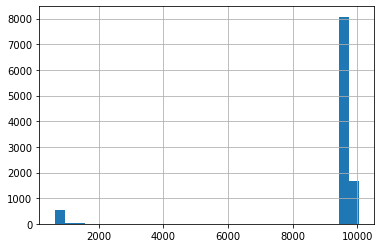

In [ ]:
pd.Series(np.apply_along_axis(lambda x : np.count_nonzero(x),axis =1,arr= M_tilde[:,:])).hist(bins=30)

## Lower partition matrix of $\tilde M$



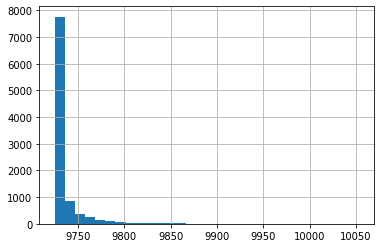

In [ ]:
pd.Series(np.apply_along_axis(lambda x : np.count_nonzero(x),axis =1,arr= M_tilde[610:,:])).hist(bins=30)

## Upper partition matrix of $\tilde M$

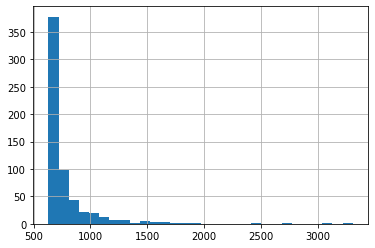

In [ ]:
pd.Series(np.apply_along_axis(lambda x : np.count_nonzero(x),axis =1,arr= M_tilde[:610,:])).hist(bins= 30)

## Right upper partition matrix of $\tilde M$ ~ $Z$

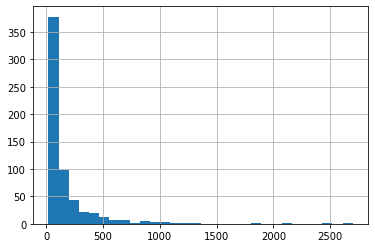

In [ ]:
pd.Series(np.apply_along_axis(lambda x : np.count_nonzero(x),axis =1,arr= M_tilde[:610,610:])).hist(bins= 30)

In [ ]:
a = (np.count_nonzero(M_tilde[:610,610:])/(M_tilde[:610,610:].shape[0]*M_tilde[:610,610:].shape[1]))*100
print(f"Z 가 대략 위치하는 영역에 발생하는 0이 아닌 값들의 비율 {a}%")

Z 가 대략 위치하는 영역에 발생하는 0이 아닌 값들의 비율 1.6999683055613624%


# SKAP

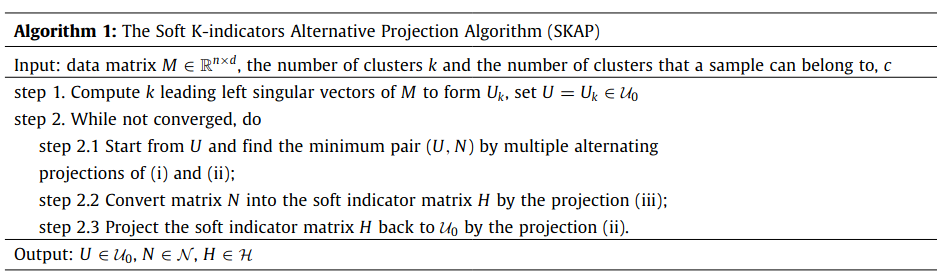

# Step 2-1

- left singular vectors of M

- k = 1000

The eigenvectors of $MM^T$



In [ ]:
from numpy import linalg as LA

In [ ]:
W,U=LA.eig(np.dot(M_tilde , M_tilde.T))

In [ ]:
#np.save("U.npy", U)
U = np.load("U.npy")

In [ ]:
#u,s,vh=LA.svd(M_tilde,full_matrices = True)

### Example

In [ ]:
Uk=U[:,:1000]
Projection_onto_N=Uk[:,:]

In [ ]:
Projection_onto_N[Projection_onto_N<0] = 0

In [ ]:
Projection_onto_N.shape

(10334, 1000)

In [ ]:
A,S,B_T=LA.svd(np.dot(Uk.T , Projection_onto_N),full_matrices = True)

In [ ]:
Projection_onto_u0 =np.dot(Uk,np.dot(A,B_T))

In [ ]:
Projection_onto_u0 

In [ ]:
np.sum((Projection_onto_u0 - Projection_onto_N)**2)

(8.05143357171989e-26+0j)

## Define a function for step2_1


## Define a function for (ii)


In [ ]:
def function_ii(given_uk,N) :
  A,S,B_T=LA.svd(np.dot(given_uk.T , N),full_matrices = True)
  Projection_onto_u0 =np.dot(given_uk,np.dot(A,B_T))
  return Projection_onto_u0

In [ ]:
Uk=U[:,:1000]

In [ ]:
def a_step2_1(given_Uk):
  '''
  input 
    given_Uk : k leading left singular vectors

  output 
    Uk and N
  '''
  Projection_onto_N=given_Uk[:,:]
  Projection_onto_N[Projection_onto_N<0] = 0
  
  Projection_onto_u0 = function_ii(given_Uk, Projection_onto_N)
  
  error=np.sum(np.abs(Projection_onto_u0 - Projection_onto_N))

  return error , Projection_onto_N ,Projection_onto_u0


In [ ]:
out = []
result = None 
for i in range(20):
  if i == 0 :
    out.append(a_step2_1(Uk))
  else:
    out.append(a_step2_1(out[i-1][2]))
  print(out[i][0])

In [ ]:
out[10][0] # minimum casse

3.7747220502797426e-10

# Step2-2

- From the above result, we convert matrix N into the soft indicator matrix H by the projection (iii).

- $c= log_2(k)$

## Example

In [ ]:
c = np.log2(1000)
c = int(np.ceil(c))

In [ ]:
candicate_N = out[10][1]

In [ ]:
# Checking nonzero values
np.apply_along_axis(lambda x : np.count_nonzero(x),axis =0,arr= candicate_N)

## How to get the top k largest values in numpy array



In [ ]:
a = np.array([9, 4, 4, 3, 3, 9, 0, 4, 6, 0])
print(a)
a.argsort()[-10:]

[9 4 4 3 3 9 0 4 6 0]


array([6, 9, 3, 4, 1, 2, 7, 8, 0, 5])

In [ ]:
def Hij(row):
  row[row.argsort()[:-10]] = 0

  return row


In [ ]:
Hij_matrix=np.apply_along_axis(lambda x : Hij(x),axis =1,arr= candicate_N)


In [ ]:
# nonzero value checking
np.apply_along_axis(lambda x : np.count_nonzero(x),axis =0,arr= Hij_matrix)

In [ ]:
np.divide(Hij_matrix,np.linalg.norm(Hij_matrix,axis = 0)).sum(0)

In [ ]:
Hij_matrix[:,6][Hij_matrix[:,6] !=0] # 

array([], dtype=complex128)

In [ ]:
np.apply_along_axis(lambda x : sum(x**2),axis = 0,arr=np.divide(Hij_matrix,np.linalg.norm(Hij_matrix,axis = 0))).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(1000,)

In [ ]:
projection_from_N_to_H = np.divide(Hij_matrix,np.linalg.norm(Hij_matrix,axis = 0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [ ]:
projection_from_N_to_H[np.isnan(projection_from_N_to_H)] = 0 # 여기 아마 수정해야할 것임. 위에서 완전히 결측 생기는 column 때문에 이렇게 만들었는데 이후 시행에서 반복해서 전부 0으로 되어버릴 것 같음.

In [ ]:
projection_from_N_to_H

In [ ]:
projection_from_N_to_H

In [ ]:
out[10][2].shape

(10334, 1000)

In [ ]:
projection_from_N_to_H=np.real(projection_from_N_to_H)

In [ ]:
projection_from_N_to_H[np.isnan(projection_from_N_to_H)] = 0

# Step3

In [ ]:
function_ii(out[10][2],projection_from_N_to_H)

In [ ]:
Hij_matrix

array([[0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
        0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
        0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.02755294+0.j, 0.0226839 +0.j, 0.        +0.j, ...,
        0.        +0.j, 0.        +0.j, 0.        +0.j],
       ...,
       [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
        0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
        0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
        0.        +0.j, 0.        +0.j, 0.        +0.j]])